# Pruebas de Rendimiento Sistemas de Seguimiento

En este documento se busca describir el proceso de toma de pruebas de rendimiento a los sistemas de seguimiento aplicados para este proyecto. 

Algunas de las pruebas que se espera realizar y graficar son:

1. **Tasa de Interrupción de Trayectoria (Trajectory Fragmentation Rate):**
    - Mide la frecuencia con la que un objeto pierde su identidad asignada y luego es reasignado a una nueva identidad.
2. **Tasa de Cambio de Identidad (Identity Switch Rate):**
    - Calcula con qué frecuencia un objeto es identificado incorrectamente como otro objeto.
3. **Tiempo Promedio de Seguimiento Exitoso (Average Successful Tracking Time):**
    - Evalúa el tiempo promedio durante el cual un objeto es rastreado de manera continua y precisa.
4. **Duración de las Pérdidas (Duration of Losses):**
    - Mide el tiempo promedio en que un objeto está perdido antes de ser correctamente reidentificado.

Para comenzar, lo más importante es definir un video de prueba etiquetado con los segmentos e identificadores únicos de cada vehículo, para utilizarlo como base de prueba (Ground Truth) al comparar los resultados.

In [3]:
import cv2
import os
from ultralytics import YOLO
import numpy as np
import csv
from sort import Sort
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def resize_frame(frame, max_width=1280, max_height=720):
    h, w = frame.shape[:2]
    scale = min(max_width / w, max_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(frame, (new_w, new_h))

In [3]:
def extract_frames(video_path, frames_folder, detections_folder, interval):
    """
    Extracts frames from a video and saves YOLO detection results to separate CSV files for each frame.
    
    :param video_path: Path to the video file.
    :param target_folder: Folder to save the extracted frames and detection CSVs.
    :param interval: Extract a frame every 'interval' frames.
    """
    model = YOLO("D:/Titulo/Github/vehicle_video_trajectory_extractor/models/cutom_dota.pt")
    tracker = Sort(max_age=15)

    # Make sure the target folder exists
    if not os.path.exists(frames_folder):
        os.makedirs(frames_folder)

    # Make sure the target folder exists
    if not os.path.exists(detections_folder):
        os.makedirs(detections_folder)
    
    # Open the video
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    frame_idx = 0  # Frame index
    while True:
        ret, frame = video.read()
        if not ret:
            break  # Break the loop if there are no frames to read
        
        results = model(frame, stream=True, verbose=False) # Assuming this is how you get results
        X_DATA = []
        for res in results:
            #filtrado y seguimiento de objetos
            data = res.boxes.data.cpu().numpy()
            tracks = tracker.update(data)
            new_data = []
            for i in range(len(tracks)):
                xmin, ymin, xmax, ymax, conf, class_id, track_id = tracks[i]
                xmin, ymin, xmax, ymax, track_id = int(xmin), int(ymin), int(xmax), int(ymax), int(track_id)
                class_name = res.names[int(class_id)]
                new_data.append([xmin, ymin, xmax, ymax, conf, class_name, track_id])
                #dibujado de resultados
                cv2.putText(img=frame, text=f"{track_id}", org=(xmin, ymin-10), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(0,255,0), thickness=2)
                cv2.circle(img=frame, center=(int((xmin + xmax) / 2), int((ymin + ymax) / 2)), radius=0, color=(0, 0, 255), thickness=2)
            X_DATA.append(new_data)
        resized_frame = resize_frame(frame)
        cv2.imshow("frame", resized_frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        # Save a frame and its detections every 'interval' frames
    
        frame_path = os.path.join(frames_folder, f"{frame_idx}.jpg")
        cv2.imwrite(frame_path, frame)
        print(f"Extracted frame {frame_idx}")

        # Create a CSV file for this frame's detections
        csv_path = os.path.join(detections_folder, f"{frame_idx}.csv")
        with open(csv_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["x1", "y1", "x2", "y2", "confidence", "class_id", "track_id"])
            
            for res in X_DATA:
                for detection in res:
                    # Assuming detection is [x1, y1, x2, y2, confidence, class_id]
                    writer.writerow(detection)
        
        print(f"Saved detections for frame {frame_idx}")
        
        frame_idx += 1
    
    video.release()  # Release the video object
    print("Finished extracting frames and saving detection results.")

# Example usage
video_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/cropped_video1_4k_30s.mp4'
frames_folder = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/frames'
detections_folder = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'
interval = 30  # Extract a frame every 30 frames

extract_frames(video_path, frames_folder, detections_folder, interval)


Extracted frame 0
Saved detections for frame 0
Extracted frame 1
Saved detections for frame 1
Extracted frame 2
Saved detections for frame 2
Extracted frame 3
Saved detections for frame 3
Extracted frame 4
Saved detections for frame 4
Extracted frame 5
Saved detections for frame 5
Extracted frame 6
Saved detections for frame 6
Extracted frame 7
Saved detections for frame 7
Extracted frame 8
Saved detections for frame 8
Extracted frame 9
Saved detections for frame 9
Extracted frame 10
Saved detections for frame 10
Extracted frame 11
Saved detections for frame 11
Extracted frame 12
Saved detections for frame 12
Extracted frame 13
Saved detections for frame 13
Extracted frame 14
Saved detections for frame 14
Extracted frame 15
Saved detections for frame 15
Extracted frame 16
Saved detections for frame 16
Extracted frame 17
Saved detections for frame 17
Extracted frame 18
Saved detections for frame 18
Extracted frame 19
Saved detections for frame 19
Extracted frame 20
Saved detections for 

In [4]:
import cv2
import os

def crop_center_and_save_as_video(video_path, output_video_path, crop_width, crop_height):
    """
    Crops the center of each frame of a video and saves the result as a new video.
    
    :param video_path: Path to the video file.
    :param output_video_path: Path where the output video will be saved.
    :param crop_width: Width of the crop area.
    :param crop_height: Height of the crop area.
    """
    # Open the video
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    # Get video properties
    fps = video.get(cv2.CAP_PROP_FPS)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec used to compress the frames
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (crop_width, crop_height))
    
    while True:
        ret, frame = video.read()
        if not ret:
            break  # No more frames to read
        
        # Get frame dimensions
        height, width = frame.shape[:2]
        
        # Calculate the top left corner of the crop area
        start_x = width // 2 - crop_width // 2
        start_y = height // 2 - crop_height // 2
        
        # Crop the frame
        cropped_frame = frame[start_y:start_y+crop_height, start_x:start_x+crop_width]
        
        # Write the cropped frame to the output video
        out.write(cropped_frame)
    
    # Release everything when job is finished
    video.release()
    out.release()
    print("Finished cropping and saving video.")

# Example usage
video_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/video1_4k_30s_sift_estabilizado_filtrado.mp4'
output_video_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/cropped_video1_4k_30s.mp4'  # Replace with the path for the output video
crop_width = 1280  # Width of the crop area in pixels
crop_height = 720  # Height of the crop area in pixels

crop_center_and_save_as_video(video_path, output_video_path, crop_width, crop_height)


Finished cropping and saving video.


In [20]:
import pandas as pd
import os

def replace_track_id_in_csv(folder_path, old_track_id, new_track_id):
    """
    Replaces an old track_id with a new track_id in all CSV files within the specified folder.
    
    :param folder_path: Path to the folder containing CSV files.
    :param old_track_id: The track_id value to search for.
    :param new_track_id: The new track_id value to replace with.
    """
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Check if 'track_id' column exists to avoid KeyError
            if 'track_id' in df.columns:
                # Replace the old_track_id with new_track_id
                df['track_id'] = df['track_id'].replace(old_track_id, new_track_id)
                
                # Save the modified DataFrame back to CSV
                df.to_csv(file_path, index=False)
                print(f"Processed and updated {filename}")
            else:
                print(f"'track_id' column not found in {filename}")
    print("Finished processing all files.")

# Example usage
folder_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'  # Replace with the path to your folder containing CSV files
old_track_id = 129  # The track_id you want to replace
new_track_id = 26  # The new track_id value

replace_track_id_in_csv(folder_path, old_track_id, new_track_id)

Processed and updated 0.csv
Processed and updated 1.csv
Processed and updated 10.csv
Processed and updated 100.csv
Processed and updated 101.csv
Processed and updated 102.csv
Processed and updated 103.csv
Processed and updated 104.csv
Processed and updated 105.csv
Processed and updated 106.csv
Processed and updated 107.csv
Processed and updated 108.csv
Processed and updated 109.csv
Processed and updated 11.csv
Processed and updated 110.csv
Processed and updated 111.csv
Processed and updated 112.csv
Processed and updated 113.csv
Processed and updated 114.csv
Processed and updated 115.csv
Processed and updated 116.csv
Processed and updated 117.csv
Processed and updated 118.csv
Processed and updated 119.csv
Processed and updated 12.csv
Processed and updated 120.csv
Processed and updated 121.csv
Processed and updated 122.csv
Processed and updated 123.csv
Processed and updated 124.csv
Processed and updated 125.csv
Processed and updated 126.csv
Processed and updated 127.csv
Processed and upd

In [21]:
import pandas as pd
import os

def remove_duplicate_track_ids(folder_path):
    """
    Removes duplicate rows based on 'track_id' in all CSV files within the specified folder,
    keeping only the first occurrence and deleting the rest.
    
    :param folder_path: Path to the folder containing CSV files.
    """
    # Iterate over all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Check if 'track_id' column exists to avoid KeyError
            if 'track_id' in df.columns:
                # Remove duplicates, keeping the first occurrence
                df = df.drop_duplicates(subset=['track_id'], keep='first')
                
                # Save the modified DataFrame back to CSV, overwriting the original file
                df.to_csv(file_path, index=False)
                print(f"Processed and updated {filename}")
            else:
                print(f"'track_id' column not found in {filename}")
    print("Finished processing all files.")

# Example usage
folder_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'  # Replace with the path to your folder containing CSV files

remove_duplicate_track_ids(folder_path)


Processed and updated 0.csv
Processed and updated 1.csv
Processed and updated 10.csv
Processed and updated 100.csv
Processed and updated 101.csv
Processed and updated 102.csv
Processed and updated 103.csv
Processed and updated 104.csv
Processed and updated 105.csv
Processed and updated 106.csv
Processed and updated 107.csv
Processed and updated 108.csv
Processed and updated 109.csv
Processed and updated 11.csv
Processed and updated 110.csv
Processed and updated 111.csv
Processed and updated 112.csv
Processed and updated 113.csv
Processed and updated 114.csv
Processed and updated 115.csv
Processed and updated 116.csv
Processed and updated 117.csv
Processed and updated 118.csv
Processed and updated 119.csv
Processed and updated 12.csv
Processed and updated 120.csv
Processed and updated 121.csv
Processed and updated 122.csv
Processed and updated 123.csv
Processed and updated 124.csv
Processed and updated 125.csv
Processed and updated 126.csv
Processed and updated 127.csv
Processed and upd

In [5]:
from matplotlib import pyplot as plt
import pandas as pd


def count_new_ids_per_frame(folder_path):
    """
    Counts the number of new track_ids per frame.
    """
    new_ids_per_frame = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Check if 'track_id' column exists to avoid KeyError
            if 'track_id' in df.columns:
                # Get the number of unique track_ids in this frame
                new_ids_per_frame.append(len(df['track_id'].unique()))
            else:
                print(f"'track_id' column not found in {filename}")
    print("Finished processing all files.")
    
    # Plot the results
    plt.plot(new_ids_per_frame)
    plt.xlabel("Frame")
    plt.ylabel("Number of new track_ids")
    plt.show()

folder_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'  # Replace with the path to your folder containing CSV files
count_new_ids_per_frame(folder_path)

Finished processing all files.


In [6]:
def add_sort_tracks(folder_path):
    """
    Counts the number of new track_ids per frame.
    """
    new_ids_per_frame = []
    tracker = Sort(max_age=15)

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            # gather all the rows of the dataframe into a ndarray
            data = df.to_numpy()
            tracks = tracker.update(data)

            # take the tracks ndarray and convert it back to a dataframe 
            df = pd.DataFrame(tracks, columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class_id', 'track_id', 'sort_id'])
            
            # Writes the DataFrame back to CSV, overwriting the original file
            df.to_csv(file_path, index=False)
            print(f"Processed and updated {filename}")
    print("Finished processing all files.")
    

folder_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'  # Replace with the path to your folder containing CSV files
add_sort_tracks(folder_path)

Processed and updated 0.csv
Processed and updated 1.csv
Processed and updated 10.csv
Processed and updated 100.csv
Processed and updated 101.csv
Processed and updated 102.csv
Processed and updated 103.csv
Processed and updated 104.csv
Processed and updated 105.csv
Processed and updated 106.csv
Processed and updated 107.csv
Processed and updated 108.csv
Processed and updated 109.csv
Processed and updated 11.csv
Processed and updated 110.csv
Processed and updated 111.csv
Processed and updated 112.csv
Processed and updated 113.csv
Processed and updated 114.csv
Processed and updated 115.csv
Processed and updated 116.csv
Processed and updated 117.csv
Processed and updated 118.csv
Processed and updated 119.csv
Processed and updated 12.csv
Processed and updated 120.csv
Processed and updated 121.csv
Processed and updated 122.csv
Processed and updated 123.csv
Processed and updated 124.csv
Processed and updated 125.csv
Processed and updated 126.csv
Processed and updated 127.csv
Processed and upd

In [6]:
from collections import defaultdict

import cv2
import numpy as np

from ultralytics import YOLO

def yolov8_bytetrack_cumulative_new_ids(video_path):
    # Load the YOLOv8 model
    model = YOLO('D:/Titulo/Github/vehicle_video_trajectory_extractor/models/cutom_dota.pt')

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Store the track history
    track_history = defaultdict(lambda: [])

    cumulative_new_ids = []
    seen_ids = set()
    total_new_ids = 0

    # Loop through the video frames
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, imgsz=1280)

            # Get the boxes and track IDs
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Visualize the results on the frame
            annotated_frame = results[0].plot()
            tracks = []
            # Plot the tracks
            for box, track_id in zip(boxes, track_ids):
                tracks.append(track_id)
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=2)

            current_frame_ids = set(tracks)
            new_ids = current_frame_ids - seen_ids
            total_new_ids += len(new_ids)
            cumulative_new_ids.append(total_new_ids)
            seen_ids.update(new_ids)

            # Display the annotated frame
            cv2.imshow("YOLOv8 Tracking", annotated_frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break

    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()

    return cumulative_new_ids

video_path = "D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/cropped_video1_4k_30s.mp4"
bytetrack_cunulative_ids = yolov8_bytetrack_cumulative_new_ids(video_path)


0: 736x1280 18 small vehicles, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 18 small vehicles, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 large vehicles, 22 small vehicles, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 large vehicles, 22 small vehicles, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 large vehicles, 22 small vehicles, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 large vehicles, 22 small vehicles, 7.0ms
Speed: 5.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 large vehicles, 22 small vehicles, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 2.0ms postprocess pe

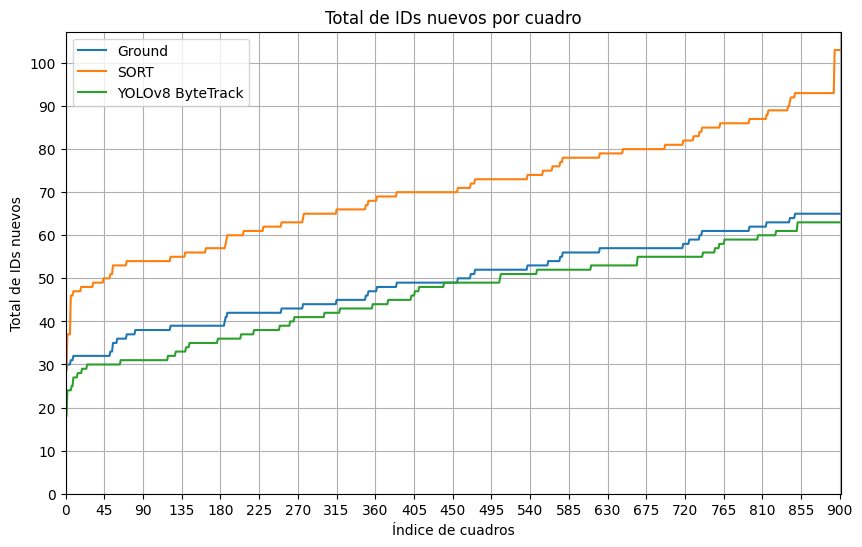

In [8]:
def track_cumulative_new_ids(folder_path, id_column_name):
    """
    Tracks the cumulative count of new IDs per frame.
    
    :param folder_path: Path to the folder containing CSV files.
    :param id_column_name: Name of the column that contains the IDs.
    :return: A list with the cumulative count of new IDs.
    """
    cumulative_new_ids = []
    seen_ids = set()
    total_new_ids = 0
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            
            if id_column_name in df.columns:
                current_frame_ids = set(df[id_column_name])
                new_ids = current_frame_ids - seen_ids
                total_new_ids += len(new_ids)
                cumulative_new_ids.append(total_new_ids)
                seen_ids.update(new_ids)
            else:
                print(f"'{id_column_name}' column not found in {filename}")
    
    return cumulative_new_ids

def plot_cumulative_new_ids(cumulative_ids_series, labels=None):
    """
    Plots multiple series of cumulative new IDs in different colors.
    
    :param cumulative_ids_series: A list of lists, where each inner list is a series of cumulative new IDs.
    :param labels: An optional list of labels for each series.
    """
    plt.figure(figsize=(10, 6))
    
    for i, series in enumerate(cumulative_ids_series):
        if labels and i < len(labels):
            plt.plot(series, label=labels[i])
        else:
            plt.plot(series)
    
    plt.xlabel("Índice de cuadros")
    plt.ylabel("Total de IDs nuevos")
    plt.title("Total de IDs nuevos por cuadro")
    plt.legend() if labels else None

    # Adjusting grid lines
    max_x = len(cumulative_ids_series[1])
    max_y = max(cumulative_ids_series[1])
    plt.xticks(np.arange(0, max_x, max_x // 20))  # Divide x-axis into 20 intervals
    plt.yticks(np.arange(0, max_y + 1, max_y // 10))  # Divide y-axis into 10 intervals
    plt.xlim(0, max_x)
    plt.grid(True)
    plt.show()

folder_path = 'D:/Titulo/Github/vehicle_video_trajectory_extractor/videos/detections'  # Replace with the path to your folder containing CSV files

# Track cumulative new IDs
tracks_new_ids = track_cumulative_new_ids(folder_path, 'track_id')
sort_new_ids = track_cumulative_new_ids(folder_path, 'sort_id')

# Plot the results
plot_cumulative_new_ids([tracks_new_ids, sort_new_ids, bytetrack_cunulative_ids], labels=['Ground', 'SORT', 'YOLOv8 ByteTrack'])